# **Global Peatland Rapid Assessment**
<span style = "font-size: 1.5em;"> ***PEATMAP: Global Peatland Distribution*** </span>

## Brief Description

### <span style = "font-size: 1em;"> ***Brief Description of The Asssessment*** </span>

The assessment will estimate the spatial distribution of peat area in the region of interest. Moreover, the level of degradation will be assessed by using Hansen Forest Change and Tropical Humid Forest by assuming peat degradation will occurr in the non-forested peat

<span style="font-size:1.1em;"> ***Input Data Needed*** </span>
- Shapefile
> - **roi_directory** : specify region of interest shapefiile
> - **peat_directory** : select the global peatland shapefile

- Input Data Variables
> - **projectname (string)** : project name (example: "RVL_IDN_KubuRaya")
> - **projection**: UTM projection code in code (example: "EPSG:3857")
> - **roi_column_name** : variable name that specifiy unique ID for multipolygon analysis (example: "Name")
> - **forest_threshold** : minimum percentage of Hanssen tree cover to defined foret area (example: 30)
> - **min_forest_map_area** : specify the minimum mapping area (pixel units) to specify the minimum area to defined as forest (example: 0.5 Ha = 6 pixels; 1 Ha = 11 pixels; 2 Ha = 22 pixels)
> - **min_forestloss_map_area** : specify the minimum mapping area (pixel units) to specify the minimum area to defined as forest loss (example: 0.5 Ha = 6 pixels; 1 Ha = 11 pixels; 2 Ha = 22 pixels)
> - **tileScale** : In case any error/issue of computation memory while running the calculation in very large or small area (example: 4). [See this for further explanation](https://gis.stackexchange.com/questions/373250/understanding-tilescale-in-earth-engine)

- Output directory folder
> - **output_directory** : select directory folder to put the output result

<span style="font-size:1.1em;"> ***Expected Output*** </span>
- Raster Datasets
> - Primary forest and Non-primary forest in 2001 and 2022
> - Primary and non-primary forest loss in 2002-2021

- csv, graph and maps 
> - Peat Extent Area (Ha)
> - Degraded peat in 2001 and 2022 Area (Ha)

### <span style = "font-size: 1em;"> ***Brief Description of The Dataset*** </span>

The data shows the distribution of global peatland area (Ha) which was derived from the compilation of most detailed and up-to-date available datasets at global, regional and local from multiple sources. The datasets was selected based on **relevancies** (the ability to **identify and distinguish peatland from other land cover**); **Spatial Resoltuion** (the finest and **detail resolution**); **Age** (the most **latest version** datasets available)

<img src="https://i.ibb.co/jys817N/PEATMAP-data-sources-list.png" alt="PEATMAP-data-sources-list" border="0"></a>

<span style="font-size:1.1em;"> ***Source*** </span>
1. PEATMAP
Xu, Jiren and Morris, Paul J. and Liu, Junguo and Holden, Joseph (2017) PEATMAP: Refining estimates of global peatland distribution based on a meta-analysis. University of Leeds. [Dataset] https://doi.org/10.5518/252
2. Hansen Tree Cover and Forest Loss
Hansen, M. C., P. V. Potapov, R. Moore, M. Hancher, S. A. Turubanova, A. Tyukavina, D. Thau, S. V. Stehman, S. J. Goetz, T. R. Loveland, A. Kommareddy, A. Egorov, L. Chini, C. O. Justice, and J. R. G. Townshend. 2013. "High-Resolution Global Maps of 21st-Century Forest Cover Change." Science 342 (15 November): 850-53. 10.1126/science.1244693 Data available on-line at: https://glad.earthengine.app/view/global-forest-change.
3. Primary Humid Tropical Forest
Turubanova S., Potapov P., Tyukavina, A., and Hansen M. (2018) Ongoing primary forest loss in Brazil, Democratic Republic of the Congo, and Indonesia. Environmental Research Letters. https://doi.org/10.1088/1748-9326/aacd1c

### <span style = "font-size: 1em;"> ***Note*** </span>

1. The script will only estimate the **peat extent area** since peat depth information is unavailable in PEATMAP dataset
2. Hansen Forest Change will be applied in the **Peat and Non-peat Area**
3. To estimate peat degradation, raster calculation will be applied on the Hansen Raster datassets. Geemap package only allow to export the data to google drive, hence,  before proceed with the **Peat Degradation Assessment Sections**, make sure **the datasets has been downloaded from google drive to the local storage**

## Data Preparation

### Import modules and Relevant Datasets

In [1]:
%matplotlib inline
import os
import rasterio
from rasterio.plot import show
import geopandas as gpd
import pandas as pd
from tkinter import Tk, filedialog, simpledialog, messagebox
from tkinter import * 
import rioxarray as rxr
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from matplotlib import colors
from matplotlib.patches import Patch
import geoplot as gplt
import contextily as ctx
import plotly.express as px
import numpy as np
from geocube.api.core import make_geocube
from rasterstats import zonal_stats
from geemap import cartoee
import geoplot.crs as gcrs
import mapclassify as mc
import cartopy.io.img_tiles as cimgt

In [2]:
import ee
import geemap
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

In [3]:
root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.
root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.
roi_directory = filedialog.askopenfile(title = "Open RoI Shapefile") 
peat_directory = filedialog.askopenfile(title = "Open Peatland Shapefile")
# Output folder
output_directory = filedialog.askdirectory(title = "Specify Output Folder")

In [4]:
# output directory
out_dir = os.path.expanduser(output_directory+'/geemap_degradedPeat_Hansen')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

### Specify Input Data

In [5]:
# specify project name
projectname = simpledialog.askstring("Input", "Speficy project name",parent=root)

if projectname is not None:
    print("The script will assess ", projectname)
else:
    print("Name has not been submitted, Restart the code!")
    
#Specify Projection
projection = simpledialog.askstring("Input", "Specify Projection in UTM zone, example EPSG:3857", parent=root)

if projection is not None:
    print("All data will be reprojected to ", projection, ' canopy cover')
else:
    print("Projection has not specified, Restart the code!")
    
# column name for roi id
roi_column_name = simpledialog.askstring("Input", "Specify columns name in ROI attribute table to define boundary name",parent=root)

if roi_column_name is not None:
    print("Column name is ", roi_column_name)
else:
    print("Column has not identified, Restart the code!")

The script will assess  DRC WDPA
All data will be reprojected to  EPSG:32733  canopy cover
Column name is  NAME


In [6]:
### specify for Hansen

#Specify forest_threshold
forest_threshold = simpledialog.askinteger("Input", "Specify forest threshold value to define forest",parent=root , 
                                           minvalue =0, maxvalue = 100)

if forest_threshold is not None:
    print("Forest is defined as area with >= ", forest_threshold, ' canopy cover')
else:
    print("Forest Threshold has not specified, Restart the code!")
    
# Specify minimum mapping unit - forest
min_forest_map_area = simpledialog.askinteger("Input", "Specify Min pixels area, example: 22 pixels = 2 Ha or 6 pixels = 0.5 Ha",
                                              parent=root , minvalue =0, maxvalue = 100)

if min_forest_map_area is not None:
    print("Minimum pixels size is ", min_forest_map_area)
else:
    print("Minimum pixels size has not identified, Restart the code!")

pixels = ee.Number(min_forest_map_area)
    
# Specify minimum mapping unit - forest loss
min_forestloss_map_area = simpledialog.askinteger("Input", "Specify Min pixels area, example: 22 pixels = 2 Ha or 6 pixels = 0.5 Ha",
                                                  parent=root , minvalue =0, maxvalue = 100)

if min_forestloss_map_area is not None:
    print("Minimum pixels size is ", min_forestloss_map_area)
else:
    print("Minimum pixels size has not identified, Restart the code!")

lossPixels = ee.Number(min_forestloss_map_area); 


Forest is defined as area with >=  30  canopy cover
Minimum pixels size is  6
Minimum pixels size is  6


In [7]:
# tile scale to avoid memory ran out issue
tileScale = 4

### Visualization Parameters

In [8]:
# visualization parameters
roi_kwargs = {'linewidth': 0.5, 'edgecolor': 'white'}
peat_kwargs = {'linewidth' : 0.5, 'edgecolor': None, 'facecolor': '#efb403'}
colors_peat = ['#efb403', '#674d01']
colormap = LinearSegmentedColormap.from_list([1, 2],colors_peat)

In [9]:
# Visualization Parameters
# Forest 2000- Green
vis_treecover = {'palette': ['000000', '00FF00'], 'max': 100};
# Accumulated Forest Loss 2001-2020
vis_loss = {'palette': ['FF0000']};
# Annual forest loss 2001-2020
vis_loss_year = {'palette': ['blue', 'red'], 'min':1, 'max': 21};
vis_prim_loss_year = {'palette': ['blue', 'yellow', 'red'], 'min':2, 'max': 21};
# Forest non forest map
vis_forestnonforest = {'palette': ['yellow','#008000'], 'min':0, 'max':1};

# roi polygon
vis_roi = {'color': '#FF0000', 'width': 2,'lineType': 'solid','fillColor': '00000000'}

## Spatial Distribution of Peat Extent

### Peat and Non-peat Area Estimation

In [10]:
# roi shapefile
roi = gpd.read_file(roi_directory.name)
peat = gpd.read_file(peat_directory.name)

# reproject to UTM
roi_proj  = roi.to_crs(crs = projection)
peat_proj = peat.to_crs(crs = projection)

In [11]:
# clip peatland by roi then union with roi to create peat and non-peat
# peat : 1
# non-peat: 2
peat_roi_proj = gpd.clip(peat_proj, roi_proj)
peat_roi_proj["Data"] = 1
peat_roi_proj["Data_cat"] = "Peat"
peat_nonpeat_roi_proj = gpd.overlay(roi_proj, peat_roi_proj, how = "union", keep_geom_type=True)

In [ ]:
# incase topological error is encounterd in the union process

#try:
#    peat_nonpeat_roi_proj = gpd.overlay(roi_proj, peat_roi_proj, how = "union", keep_geom_type=False)
#except (TopologicalError, TopologyException):
#    #skipping error here
#    pass

In [12]:
# calculate peat and non-peat area
peat_nonpeat_roi_proj["Area_Ha"] = peat_nonpeat_roi_proj['geometry'].area/10000
peat_nonpeat_roi_proj.Data = peat_nonpeat_roi_proj.Data.fillna(2)
peat_nonpeat_roi_proj.Data = peat_nonpeat_roi_proj.Data.astype('int64')
peat_nonpeat_roi_proj.Data_cat = peat_nonpeat_roi_proj.Data_cat.fillna("Non-peat")

# create new ID
peat_nonpeat_roi_proj['new_id'] = np.arange(len(peat_nonpeat_roi_proj))

### Data Visualization

In [13]:
peat_roi_proj_4326 = peat_roi_proj.to_crs(crs = 'EPSG:4326')
roi_proj_4326 = roi_proj.to_crs(crs = 'EPSG:4326')
peat_nonpeat_roi_proj_4326 = peat_nonpeat_roi_proj.to_crs(crs = 'EPSG:4326')
#scheme = mc.Quantiles(continental_usa_cities['POP_2010'], k=5)
scheme_pnp = mc.UserDefined(peat_nonpeat_roi_proj_4326['Data'], bins = [1, 2])

<Figure size 2160x2160 with 0 Axes>

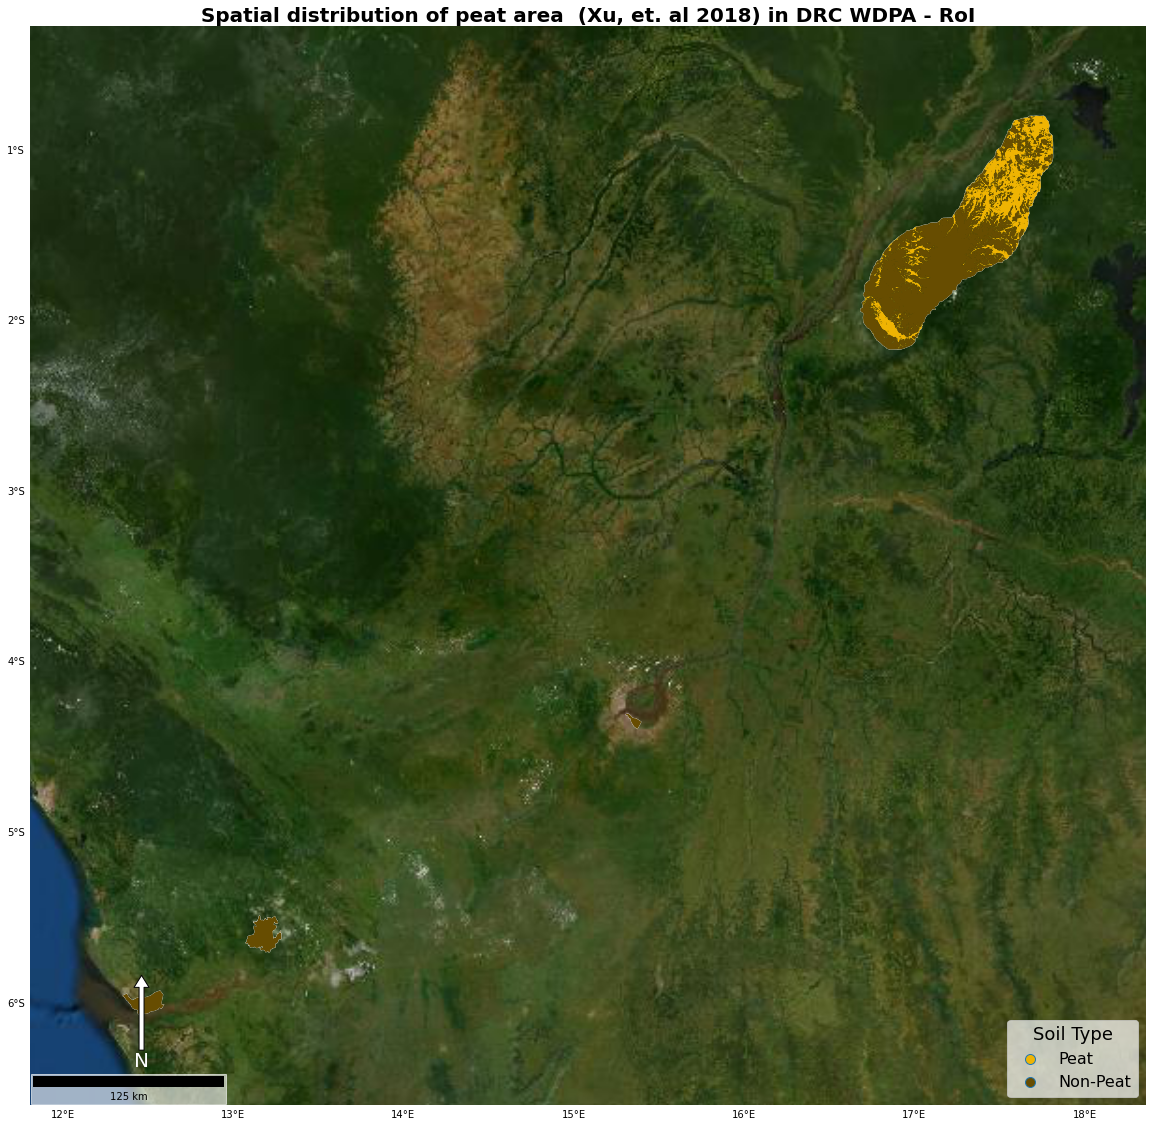

In [14]:
# Peat Map
fig_peat = plt.figure(figsize=(30,30), facecolor = 'white', frameon=True)
ax_peat = gplt.webmap(df=roi_proj_4326, projection=gcrs.WebMercator(),
                      provider=ctx.providers.Esri.WorldImagery, figsize=(20,20))
ax_peat = gplt.polyplot(roi_proj_4326, projection = gcrs.WebMercator(), **roi_kwargs, ax = ax_peat)

#ax_peat = gplt.polyplot(peat_nonpeat_roi_proj_4326, projection = gcrs.WebMercator(), **peat_kwargs, ax = ax_peat)
ax_peat = gplt.choropleth(peat_nonpeat_roi_proj_4326, hue='Data', projection=gcrs.WebMercator(),    
                          edgecolor = None, linewidth = 0.5, cmap=colormap,
                          legend=True, ax = ax_peat,
                          legend_kwargs={'frameon': True, 'framealpha' : 0.7, 'loc': 'lower right', 'fontsize' : 16, 'title':'Soil Type', 'title_fontsize' : 18},
                          legend_labels=['Peat', 'Non-Peat'],
                          scheme = scheme_pnp
)

x, y, arrow_length = 0.1, 0.12, 0.08
ax_peat.annotate('N', color='white', xy=(x, y), xytext=(x, y-arrow_length), arrowprops=dict(facecolor='white', width=5, headwidth=15),
                 ha='center', va='center', fontsize=20,
                 xycoords=ax_peat.transAxes)


ax_peat.add_artist(ScaleBar(1, box_alpha=0.6, location = 'lower left'))
ax_peat = ax_peat.gridlines(visible = None, draw_labels=True, dms=False, x_inline=False, y_inline=False)
ax_peat.top_labels=False
ax_peat.right_labels = False
plt.title("Spatial distribution of peat area  (Xu, et. al 2018) in " +  projectname + " - RoI", va = 'center_baseline', fontsize=20, fontweight="bold")
plt.savefig(os.path.join(out_dir, projectname + '_PeatDistribution_Map.png'), bbox_inches='tight', 
            facecolor=fig_peat.get_facecolor())

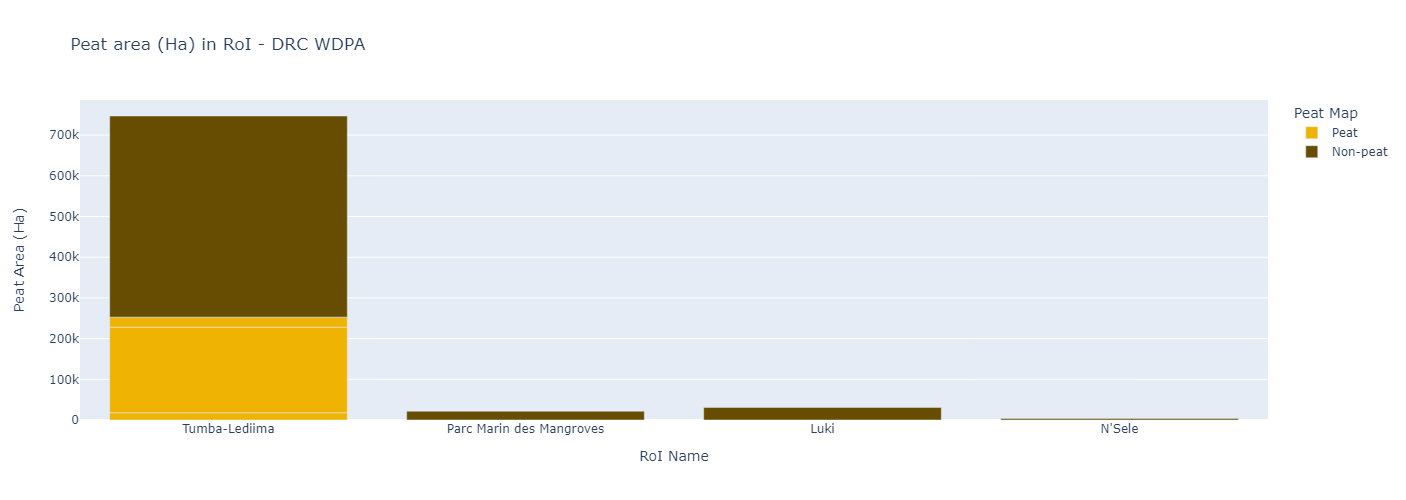

In [15]:
# Peat area in RoI
fig_peatarea = px.bar(peat_nonpeat_roi_proj, x = peat_nonpeat_roi_proj[roi_column_name],
                      y =peat_nonpeat_roi_proj.Area_Ha, color = 'Data_cat',
                      category_orders={"Peat Map": ["Peat", "Non-peat"]},
                      color_discrete_sequence = ['#efb403', '#674d01'],
                      width=1400, height=500, 
                      labels = {roi_column_name: "RoI Name","Area_Ha": "Peat Area (Ha)"},
                      title ="Peat area (Ha) in RoI - " + projectname)
fig_peatarea.update_layout(legend_title_text='Peat Map')

### Export Data

In [16]:
# 1. Peatland Area csv
peat_nonpeat_roi_proj.to_csv(os.path.join(out_dir, projectname + '_RoI_PeatArea.csv'))

# 2. peat and non-peat shapefile
peat_nonpeat_roi_proj.to_file(os.path.join(out_dir, projectname + 'peatandnonpeat.shp'))

# 3. Peat Area Graph
fig_peatarea.write_image(os.path.join(out_dir, projectname + '_RoI_PeatArea_Graph.png'))

### Processinng Check

In [17]:
if 'Peat' in peat_nonpeat_roi_proj['Data_cat'].unique():
    messagebox.showinfo("Informmation", "Peat is found, proceed to Hansen Assessment")
else:
    messagebox.showerror("Information", "Peat is not found, Peatland Assessment is Finished")

## Spatial Distribution of Degraded Peat

### Hansen Forest Change in Region of Interest

In [18]:
# Convert to ee.FeatureCollection for calculation process
peat_roi_proj_gee = geemap.geopandas_to_ee(peat_roi_proj, geodesic = False)
peat_nonpeat_roi_proj_gee = geemap.geopandas_to_ee(peat_nonpeat_roi_proj, geodesic=False)
roi_proj_gee = geemap.geopandas_to_ee(roi_proj, geodesic=False)

In [19]:
# Import Hansen image dataset
Hansen = ee.Image("UMD/hansen/global_forest_change_2021_v1_9")
primaryForests = ee.ImageCollection("UMD/GLAD/PRIMARY_HUMID_TROPICAL_FORESTS/v1").mosaic().selfMask();

# Select bands
treeCover = Hansen.select(['treecover2000']);
lossImage = Hansen.select(['loss']);
gainImage = Hansen.select(['gain']);
lossImage_year = Hansen.select(['lossyear']);
landmask = Hansen.select(['datamask']);

In [20]:
# Reproject Image to UTM
treeCover_proj = treeCover.reproject(crs = projection, scale = 30)
lossImage_proj = lossImage.reproject(crs = projection, scale = 30)
lossImage_year_proj = lossImage_year.reproject(crs = projection, scale = 30)
landmask_proj = landmask.reproject(crs = projection, scale = 30)
primaryForests_proj = primaryForests.reproject(crs = projection, scale = 30)

In [21]:
# 1. Primary Forest 2001
primaryForestContArea = primaryForests_proj.connectedPixelCount();
# Apply the minimum area on primary forest
primaryForestMinArea = primaryForestContArea.gte(pixels).selfMask();

In [22]:
# 2 Forest Map in 2000 (Non-primary forest 2000)
# 2.1 Define forest area by >= canopy cover
forest_canopy = treeCover_proj.gte(forest_threshold);

# 2.2 Define non-primary forest from pirmary forest dataset
primaryForestUnmask = primaryForestMinArea.unmask();
primaryForestEq0 = primaryForestUnmask.select('Primary_HT_forests').eq(0);

# 2.3 Mask forest canopy cover threshold with nonprimary forest
forestCC = forest_canopy.updateMask(forest_canopy.eq(1)).updateMask(landmask_proj.eq(1)).updateMask(primaryForestEq0);

# 2.4 Apply smoothing
forestContArea = forestCC.connectedPixelCount();
forestMinArea = forestContArea.gte(pixels).selfMask();

In [28]:
# 3 Accumulated Forest loss 2001-2021:

# 3.1 Accumulated Forest Loss in non-primary forest loss
# 3.1.1 Estimate forest loss in forest 2000 >= Canopy cover
maskerforestLoss = lossImage_year_proj.gte(1);
forestLoss = lossImage_proj .updateMask(forestMinArea.eq(1)).updateMask(landmask_proj.eq(1)).updateMask(maskerforestLoss);
## Create a contiguous area.
contLoss = forestLoss.connectedPixelCount();
minLoss = contLoss.gte(lossPixels).selfMask();

# 3.2 Accumulated Forest Loss 2002-2021 in Primary Forest
# 3.2.1 Estimate forest loss exclusively in primary forest
MaskedPrimaryLoss= lossImage_year_proj.gte(2); ##// loss between 2002-2021
primaryLoss = lossImage_year_proj.updateMask(MaskedPrimaryLoss).updateMask(primaryForestMinArea).updateMask(landmask_proj.eq(1))
# 3.2.2 primary loss filtered by min mapping area
contPrimaryLoss= primaryLoss.connectedPixelCount();
minPrimaryLoss = contPrimaryLoss.gte(lossPixels).selfMask();

In [30]:
# 4 Annual Forest Loss 2001-2021
# 4.1 Non-primary forest
AnnualTreeLoss = lossImage_year_proj.updateMask(forestMinArea.eq(1)).updateMask(landmask_proj.eq(1))
## Create a contiguous area.
contAnnualLoss = AnnualTreeLoss.connectedPixelCount();
minAnnualLoss = contAnnualLoss.gte(lossPixels).selfMask();
minAnnualloss_masked = lossImage_year_proj.updateMask(minAnnualLoss)

# 4.2 Primary Forest
annual_PrimaryLoss = lossImage_year_proj.updateMask(primaryForestMinArea.eq(1)).updateMask(landmask_proj.eq(1)).updateMask(MaskedPrimaryLoss.eq(1))
##** var primaryForestLoss = primaryLoss.updateMask(primaryForestMinArea);
##** Create contiguous area within primary forest loss
contAnnualPrimaryLoss = annual_PrimaryLoss.connectedPixelCount();
minAnnualPrimaryLoss = contAnnualPrimaryLoss.gte(lossPixels).selfMask();
minAnnualPrimaryLoss_masked = annual_PrimaryLoss.updateMask(minAnnualPrimaryLoss)

In [31]:
# 5. Primary Forest 2022
# Use nonLoss mask to define the non deforested area in forest map >= canopy cover
PrimaryMinLossUnmask = minPrimaryLoss.unmask();
PrimaryNotLoss = PrimaryMinLossUnmask.select('lossyear').eq(0);
PrimaryForestCover22 = primaryForestMinArea.updateMask(PrimaryNotLoss);

In [32]:
# 6. Forest Map/Non-primary forest in 2001
# 6.1 Non-primary forest loss 2001
maskerforestLoss_01 = lossImage_year_proj.eq(1);
forestLoss_01 = lossImage_proj.updateMask(forestMinArea.eq(1)).updateMask(landmask_proj.eq(1)).updateMask(maskerforestLoss_01);
## Create a contiguous area.
contLoss_01 = forestLoss_01.connectedPixelCount();
minLoss_01 = contLoss_01.gte(lossPixels).selfMask();

# 6.2 Non-primary Forest 2001
minLossUnmask_01 = minLoss_01.unmask();
notLoss_01 = minLossUnmask_01.select('loss').eq(0);
primaryForestUnmask_01 = primaryForestMinArea.unmask();
notprimaryForest_01 = primaryForestUnmask_01.select('Primary_HT_forests').eq(0);
forestCover01 = forestMinArea.updateMask(notLoss_01).updateMask(notprimaryForest_01);

In [33]:
# 6 Forest Map in 2022
# Use nonLoss mask to define the non deforested area in forest map >= canopy cover
minLossUnmask = minLoss.unmask();
notLoss = minLossUnmask.select('loss').eq(0);
primaryForestUnmask = primaryForestMinArea.unmask();
notprimaryForest = primaryForestUnmask.select('Primary_HT_forests').eq(0);
forestCover22 = forestMinArea.updateMask(notLoss).updateMask(notprimaryForest);

In [34]:
# clip raster by roi, buffer 3km, buffer 10km to avoid error
# 1. Forest 2000 and 2022
FNF_00_Final = forestMinArea.clip(roi_proj_gee)
FNF_01_Final = forestCover01.clip(roi_proj_gee)
FNF_22_Final = forestCover22.clip(roi_proj_gee)

# 2. Primary Forest 2000
PF_01_Final = primaryForestMinArea.clip(roi_proj_gee)
PF_22_Final = PrimaryForestCover22.clip(roi_proj_gee)

# 3. Annual Forest Loss 2001-2022
Annual_FL_01_21_Final = minAnnualloss_masked.clip(roi_proj_gee)

# 4. Annual Primary Forest Loss 2001-2022
Annual_PFL_02_21_Final = minAnnualPrimaryLoss_masked.clip(roi_proj_gee)

### Data Visualization

In [35]:
Map = geemap.Map()
Map.centerObject(roi_proj_gee, 10)

# 1. RoI and buffer
Map.addLayer(peat_nonpeat_roi_proj_gee.style(**vis_roi), {}, "Region of Interest")
# 2 Forest in 2000
Map.addLayer(forestMinArea.clip(peat_nonpeat_roi_proj_gee), vis_forestnonforest, "Forest/Non-forest 2000")
Map.addLayer(primaryForestMinArea.clip(peat_nonpeat_roi_proj_gee), vis_forestnonforest, 'Primary Forest 2001')
Map.addLayer(forestCover01.clip(peat_nonpeat_roi_proj_gee), vis_forestnonforest, "Forest/Non-forest 2001")
# 3 Forest Loss in 2001 -2021
Map.addLayer(minLoss.clip(peat_nonpeat_roi_proj_gee), vis_loss_year, "Accumulated Forest Loss 2001-2021")
Map.addLayer(minPrimaryLoss.clip(peat_nonpeat_roi_proj_gee), vis_loss_year, "Accumulated Forest Loss in Primary Forest 2001-2021")
Map.addLayer(minAnnualloss_masked.clip(peat_nonpeat_roi_proj_gee), vis_loss_year, "Annual Forest Loss 2001-2021", False)
Map.addLayer(minAnnualPrimaryLoss_masked.clip(peat_nonpeat_roi_proj_gee), vis_loss_year, 'Annual Primary Forest Loss 2002-2021', False)

# 4. Forest in 2022
#Map.addLayer(forestCover22.clip(peat_nonpeat_roi_proj_gee), vis_forestnonforest, 'Forest/Non-forest 2022',False)
#Map.addLayer(PrimaryForestCover22.clip(peat_nonpeat_roi_proj_gee), vis_forestnonforest, 'Primary Forest 2022',False)

# 5. global
#Map.addLayer(minAnnualloss_masked, vis_loss_year, "Global Annual Forest Loss 2001-2021", False)
#Map.addLayer(primaryForestMinArea, vis_forestnonforest, 'global primary forest 2001')
#Map.addLayer(minAnnualPrimaryLoss_masked, vis_loss_year, 'global annual primary forest loss 2001-2022')

Map

Map(center=[-1.8047353470970697, 16.968255922077667], controls=(WidgetControl(options=['position', 'transparen…

### Export Hansen Rasters Data in Region of Interest

#### 1. Non-Primary Forest in 2000, 2001 and 2021

In [40]:
# 1. Forest Map 2000 - Peat and Non-peat RoI
geemap.ee_export_image_to_drive(
    FNF_00_Final,
    description = projectname + '_Forest_2000_roi',
    folder = projectname + '_GlobalPeatAsssessment',
    fileNamePrefix = projectname + '_Forest_2000_roi',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)

# 2. Forest Map 2022 - Peat and Non-peat RoI
geemap.ee_export_image_to_drive(
    FNF_22_Final,
    description = projectname + '_Forest_2022_roi',
    folder = projectname + '_GlobalPeatAsssessment',
    fileNamePrefix = projectname + '_Forest_2022_roi',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)

# 3. Forest Map 2001 - Peat and Non-peat RoI
geemap.ee_export_image_to_drive(
    FNF_01_Final,
    description = projectname + '_Forest_2001_roi',
    folder = projectname + '_GlobalPeatAsssessment',
    fileNamePrefix = projectname + '_Forest_2001_roi',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)

#### 2. Primary Forest in 2001 and 2021

In [41]:
# 1. Primary Forest Map 2000
geemap.ee_export_image_to_drive(
    PF_01_Final,
    description = projectname + '_PrimaryForest_2001_roi',
    folder = projectname + '_GlobalPeatAsssessment',
    fileNamePrefix = projectname + '_PrimaryForest_2001_roi',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)

# 2. Primary Forest Map 2022
geemap.ee_export_image_to_drive(
    PF_22_Final,
    description = projectname + '_PrimaryForest_2022_roi',
    folder = projectname + '_GlobalPeatAsssessment',
    fileNamePrefix = projectname + '_PrimaryForest_2022_roi',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)

#### 3. Primary and Non-primary Forest Loss 2001-2021

In [42]:
# 1. Forest Loss 2001-2022
geemap.ee_export_image_to_drive(
    Annual_FL_01_21_Final,
    description = projectname + '_ForestLoss_2001_2021_roi',
    folder = projectname + '_GlobalPeatAsssessment',
    fileNamePrefix = projectname + '_ForestLoss_2001_2022_roi',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)
# 2. Annual Primary Forest Loss 2002-2022
geemap.ee_export_image_to_drive(
    Annual_PFL_02_21_Final,
    description = projectname + '_PrimaryForestLoss_2002_2021_roi',
    folder = projectname + '_GlobalPeatAsssessment',
    fileNamePrefix = projectname + '_PrimaryForestLoss_2002_2021_roi',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)

## Processing Check

In [43]:
messagebox.showwarning("Warning","Ensure Hansen Rasters datasets have been downloaded to local folder before continue!")

'ok'

## Peat Degradation Assessment

### Data Preparation

In [17]:
root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.
root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.
raster_directory = filedialog.askdirectory(title = "Specify Raster Folder Directory")

In [18]:
# Import Raster Data Primary Forest
primaryforest01_geotiff = rasterio.open(os.path.join(raster_directory, projectname + '_PrimaryForest_2001_roi.tif').replace(os.sep, '/'))
AnnualprimaryforestLoss_geotiff = rasterio.open(os.path.join(raster_directory, projectname + '_PrimaryForestLoss_2002_2021_roi.tif').replace(os.sep, '/'))
primaryforest22_geotiff = rasterio.open(os.path.join(raster_directory, projectname + '_PrimaryForest_2022_roi.tif').replace(os.sep, '/'))

Nonprimaryforest01_geotiff = rasterio.open(os.path.join(raster_directory, projectname + '_Forest_2001_roi.tif').replace(os.sep, '/'))
AnnualNonprimaryforestLoss_geotiff = rasterio.open(os.path.join(raster_directory, projectname + '_ForestLoss_2001_2022_roi.tif').replace(os.sep, '/'))
Nonprimaryforest22_geotiff = rasterio.open(os.path.join(raster_directory, projectname + '_Forest_2022_roi.tif').replace(os.sep, '/'))

In [19]:
# rasterize peatland and non-peatland shapefile
out_peatnonpeat_raster = make_geocube(
    vector_data = peat_nonpeat_roi_proj,
    output_crs = projection,
    measurements=['Data'],
    resolution=(-30, 30)
)
out_peatnonpeat_raster["Data"].rio.to_raster(os.path.join(raster_directory, projectname + '_PeatNonPeat_roi.tif').replace(os.sep, '/'))

In [20]:
peatnonpeat_raster = rasterio.open(os.path.join(raster_directory, projectname + '_PeatNonPeat_roi.tif').replace(os.sep, '/'))

### Degraded Peat in 2001

#### Area Estimation - Degraded Peat in 2001 

In [21]:
# 1. Primary Forest + Non-prmary forest 2001
# Note: Primary Forest * 10 + Non-primary Forest
# 0: Non-forest
# 1: Non-primary Forest
# 10: Primary Forest
# 11: Primary Forest
# Create parameters from converting numpy to raster
upperleft_bound = primaryforest01_geotiff.transform * (0, 0)
pixel_size = primaryforest01_geotiff.transform[0]

# overlay primary + non-primary forest
forestbytype_loss_overlay = primaryforest01_geotiff.read(1) * 10 + Nonprimaryforest01_geotiff.read(1)

new_transform = rasterio.transform.from_origin(upperleft_bound[0],upperleft_bound[1],pixel_size,pixel_size)
new_dataset = rasterio.open(
    os.path.join(raster_directory, projectname + '_forestbytype_2001_roi.tif').replace(os.sep, '/'), "w+", compress="LZW",
    driver = "GTiff",
    height = forestbytype_loss_overlay.shape[0],
    width = forestbytype_loss_overlay.shape[1],
    count = 1,
    #nodata = 0,
    dtype = forestbytype_loss_overlay.dtype,
    crs = projection,
    transform = new_transform
)
new_dataset.write(forestbytype_loss_overlay, 1)
new_dataset.close()

In [22]:
PrimForestNonPrimFores_raster = rasterio.open(os.path.join(raster_directory, projectname + '_forestbytype_2001_roi.tif').replace(os.sep, '/'))

In [23]:
# overlay forest type by peat and non-peat
# peat * 100 + foresttype
#  100: non-forested peat -- degraded peat
#  101: peat - nonprimary forest -- forested peat
#  110 & 111 : peat - primary forest -- forested peat
#  200: non-peat and non-forested -- nonpeat nonforested
#  201: nonpeat - nonprimaryforest --- forested area
#  210 & 211: non peat - primary forest --- forested area

upperleft_bound2 = PrimForestNonPrimFores_raster.transform * (0, 0)
pixel_size2 = PrimForestNonPrimFores_raster.transform[0]

forestbytype_soiltype_loss_overlay = peatnonpeat_raster.read(1) * 100 + PrimForestNonPrimFores_raster.read(1)

new_transform2 = rasterio.transform.from_origin(upperleft_bound2[0],upperleft_bound2[1],pixel_size2,pixel_size2)

new_dataset_peat_forest = rasterio.open(
    os.path.join(raster_directory, projectname + '_forestbytype_2001_peatnonpeat_roi.tif').replace(os.sep, '/'), "w+", compress="LZW",
    driver = "GTiff",
    height = forestbytype_soiltype_loss_overlay.shape[0],
    width = forestbytype_soiltype_loss_overlay.shape[1],
    count = 1,
    nodata = 0,
    dtype = forestbytype_soiltype_loss_overlay.dtype,
    crs = projection,
    transform = new_transform2
)
new_dataset_peat_forest.write(forestbytype_soiltype_loss_overlay, 1)
new_dataset_peat_forest.close()

In [24]:
pnp_forest = rasterio.open(os.path.join(raster_directory, projectname + '_forestbytype_2001_peatnonpeat_roi.tif').replace(os.sep, '/'))

In [25]:
# zonal histogram of peat + foresttype 2001
zs_soiltype_foresttype = zonal_stats(vectors = peat_nonpeat_roi_proj['geometry'], 
                                     raster = os.path.join(raster_directory, projectname + '_forestbytype_2001_peatnonpeat_roi.tif').replace(os.sep, '/'), categorical=True)
zs_soiltype_foresttype_df = pd.DataFrame(zs_soiltype_foresttype).fillna(0)
# Estimate Area from pixels count
zs_soiltype_foresttype_df = zs_soiltype_foresttype_df * 30 *30 /10000
zs_soiltype_foresttype_df["total_area_ha"] = zs_soiltype_foresttype_df.sum(axis=1)
# rename coloumn based on degradation category
zs_soiltype_foresttype_df = zs_soiltype_foresttype_df.rename({ 100.0: 'Degraded Peat', 101.0: 'Non-degraded Peat', 110.0 : 'Non-degraded Peat', 
                                                               200.0: 'Non-peat Non-Forest', 201.0: 'Non-peat Non-prim Forest', 210.0:'Non-peat PrimForest'}, axis='columns')
# sum the duplicated columns
zs_soiltype_foresttype_df = zs_soiltype_foresttype_df.groupby(lambda x:x, axis=1).sum()

In [26]:
# join between degradation area table with roi_table
degradation_peatforestype_2001 = peat_nonpeat_roi_proj.join(zs_soiltype_foresttype_df)
degradation_peatforestype_2001_df = pd.DataFrame(degradation_peatforestype_2001).fillna(0)
degradation_peatforestype_2001_df = degradation_peatforestype_2001_df.loc[(degradation_peatforestype_2001_df[[roi_column_name]] != 0).all(axis=1)]

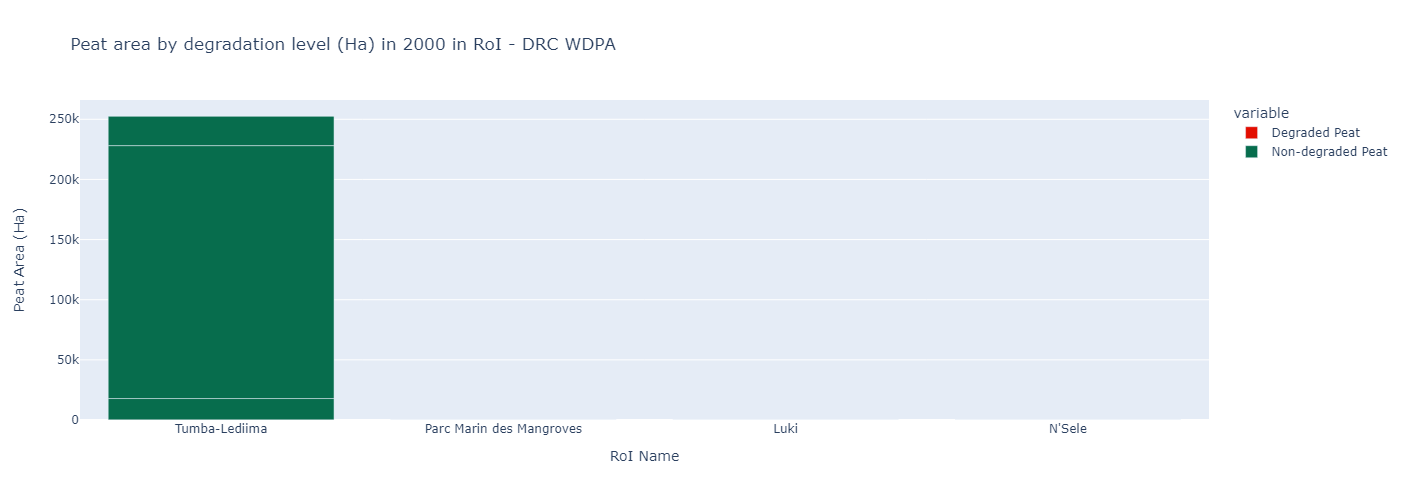

In [27]:
# Degraded Peat area in RoI
fig_degpeatarea_01 = px.bar(degradation_peatforestype_2001_df, x = roi_column_name, y = ["Degraded Peat", "Non-degraded Peat"],
                         category_orders={"Degraded Peat": ["Degraded Peat", "Non-degraded Peat"]},
                         color_discrete_sequence = ['#e30d00', '#076d4d'],
                         width=1400, height=500, 
                         labels = {roi_column_name: "RoI Name","value": "Peat Area (Ha)"},
                         title ="Peat area by degradation level (Ha) in 2000 in RoI - " + projectname)
fig_degpeatarea_01

#### Map - Degraded Peat in 2001 

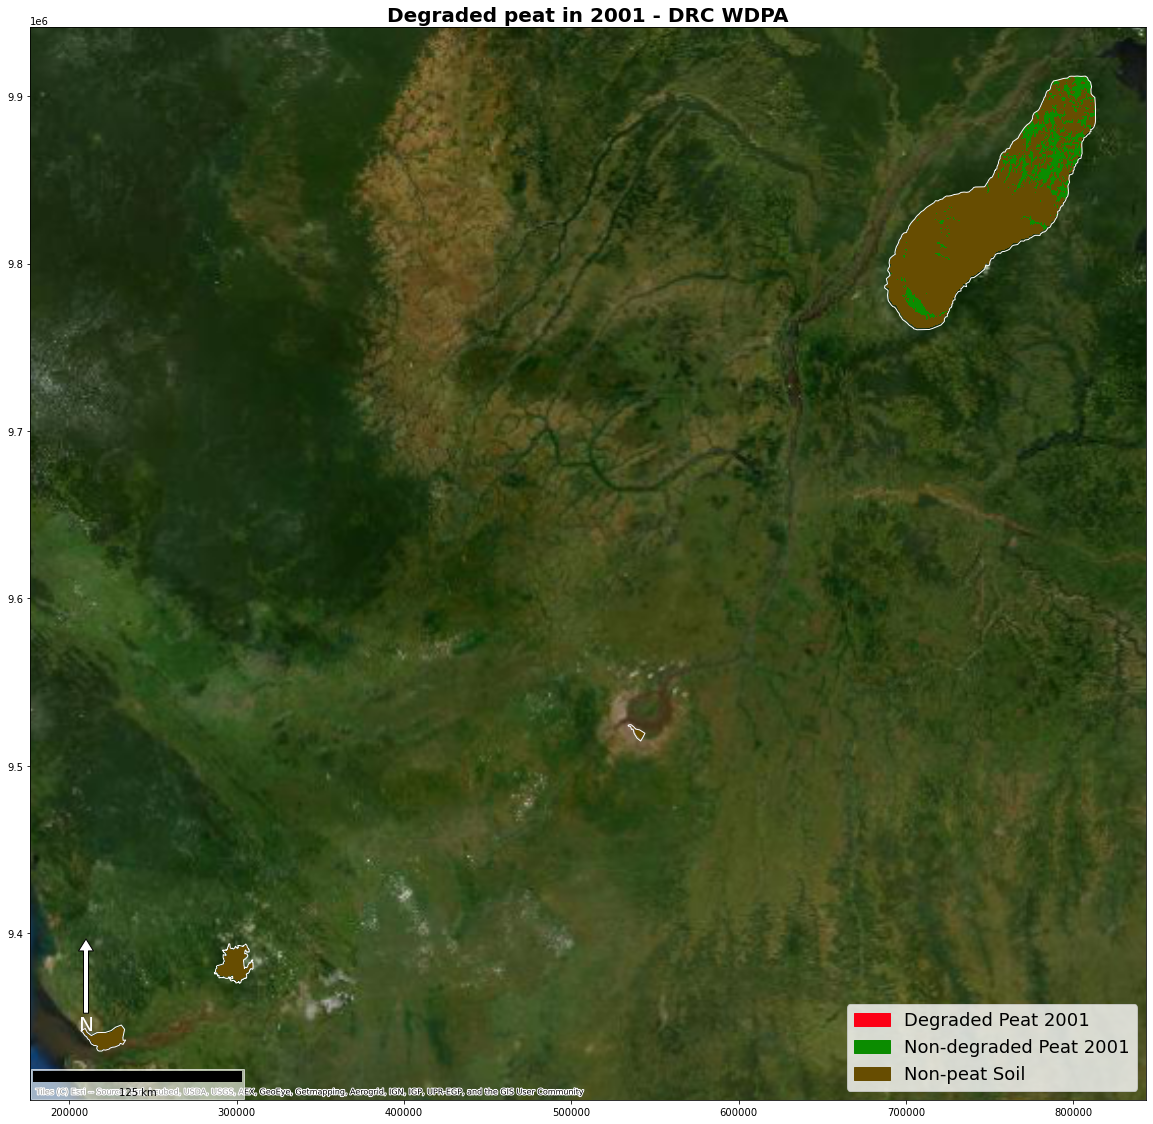

In [28]:
colors_degpeat01 = ['#fc0015','#0b8c00' ,'#674d01']
cmap_degpeat01 = ListedColormap(colors_degpeat01)
norm_degpeat_01 = colors.BoundaryNorm([0, 100.5, 111, 211], ncolors=3) #cmap_degpeat22.N, clip=False)

fig_degpeat01, ax_degpeat01 = plt.subplots(figsize=(20,20))

x, y, arrow_length = 0.05, 0.15, 0.08
ax_degpeat01.annotate('N', color='white', xy=(x, y), xytext=(x, y-arrow_length),
                      arrowprops=dict(facecolor='white', width=5, headwidth=15),
                      ha='center', va='center', fontsize=20,
                      xycoords=ax_degpeat01.transAxes)

ax_degpeat01.set_title(label='Degraded peat in 2001 - '+  projectname, fontsize=20, fontweight="bold")

legend_labels_degpeat01 = {"#fc0015": "Degraded Peat 2001",
                           "#0b8c00" : "Non-degraded Peat 2001",
                           "#674d01" : "Non-peat Soil"}
patches_degpeat01 = [Patch(color=color, label=label)
                     for color, label in legend_labels_degpeat01.items()]

ax_degpeat01.legend(handles=patches_degpeat01,facecolor="white", prop={'size': 18}, loc='lower right')
ax_degpeat01.add_artist(ScaleBar(1, box_alpha=0.6, location = 'lower left'))
ax_degpeat01 = roi_proj.plot(figsize=(20, 20), color = None, edgecolor = 'white', facecolor="none", ax = ax_degpeat01)
ax_degpeat01 = ctx.add_basemap(source=ctx.providers.Esri.WorldImagery, crs=roi_proj.crs.to_string(), ax = ax_degpeat01 )
ax_degpeat01 = rasterio.plot.show(pnp_forest, ax=ax_degpeat01, cmap = cmap_degpeat01, norm = norm_degpeat_01)

### Degraded Peat in 2022

#### Area Estimation - Degraded Peat in 2022 

In [29]:
# 2. Primary Forest + Non-prmary forest 2022
# Note: Primary Forest * 10 + Non-primary Forest
# 0: Non-forest
# 1: Non-primary Forest
# 10: Primary Forest
# 11: Primary Forest
# Create parameters from converting numpy to raster
upperleft_bound_22 = primaryforest22_geotiff.transform * (0, 0)
pixel_size_22 = primaryforest22_geotiff.transform[0]

# overlay primary + non-primary forest
forestbytype_loss_overlay_22 = primaryforest22_geotiff.read(1) * 10 + Nonprimaryforest22_geotiff.read(1)

new_transform_22 = rasterio.transform.from_origin(upperleft_bound_22[0],upperleft_bound_22[1],pixel_size_22,pixel_size_22)
new_dataset_22 = rasterio.open(
    os.path.join(raster_directory, projectname + '_forestbytype_2022_roi.tif').replace(os.sep, '/'), "w+", compress="LZW",
    driver = "GTiff",
    height = forestbytype_loss_overlay_22.shape[0],
    width = forestbytype_loss_overlay_22.shape[1],
    count = 1,
    #nodata = 0,
    dtype = forestbytype_loss_overlay_22.dtype,
    crs = projection,
    transform = new_transform_22
)
new_dataset_22.write(forestbytype_loss_overlay_22, 1)
new_dataset_22.close()

In [30]:
PrimForestNonPrimFores_22_raster = rasterio.open(os.path.join(raster_directory, projectname + '_forestbytype_2022_roi.tif').replace(os.sep, '/'))

In [31]:
# overlay forest type by peat and non-peat
# peat * 100 + foresttype
#  100: non-forested peat -- degraded peat
#  101: peat - nonprimary forest -- forested peat
#  110 & 111 : peat - primary forest -- forested peat
#  200: non-peat and non-forested -- nonpeat nonforested
#  201: nonpeat - nonprimaryforest --- forested area
#  210 & 211: non peat - primary forest --- forested area

upperleft_bound2_22 = PrimForestNonPrimFores_22_raster.transform * (0, 0)
pixel_size2_22 = PrimForestNonPrimFores_22_raster.transform[0]

forestbytype_soiltype_loss_overlay_22 = peatnonpeat_raster.read(1) * 100 + PrimForestNonPrimFores_22_raster.read(1)

new_transform2_22 = rasterio.transform.from_origin(upperleft_bound2_22[0],upperleft_bound2_22[1],pixel_size2_22,pixel_size2_22)

new_dataset_peat_forest_22 = rasterio.open(
    os.path.join(raster_directory, projectname + '_forestbytype_peatnonpeat_2022_roi.tif').replace(os.sep, '/'), "w+", compress="LZW",
    driver = "GTiff",
    height = forestbytype_soiltype_loss_overlay_22.shape[0],
    width = forestbytype_soiltype_loss_overlay_22.shape[1],
    count = 1,
    nodata = 0,
    dtype = forestbytype_soiltype_loss_overlay_22.dtype,
    crs = projection,
    transform = new_transform2_22
)
new_dataset_peat_forest_22.write(forestbytype_soiltype_loss_overlay_22, 1)
new_dataset_peat_forest_22.close()

In [32]:
pnp_forest_2022 = rasterio.open(os.path.join(raster_directory, projectname + '_forestbytype_peatnonpeat_2022_roi.tif').replace(os.sep, '/'))

In [33]:
# zonal histogram of peat + foresttype 2022
zs_soiltype_foresttype_22 = zonal_stats(vectors = peat_nonpeat_roi_proj['geometry'], 
                                        raster = os.path.join(raster_directory, projectname + '_forestbytype_peatnonpeat_2022_roi.tif').replace(os.sep, '/'), categorical=True)
zs_soiltype_foresttype_22_df = pd.DataFrame(zs_soiltype_foresttype_22).fillna(0)
# Estimate Area from pixels count
zs_soiltype_foresttype_22_df = zs_soiltype_foresttype_22_df * 30 *30 /10000
zs_soiltype_foresttype_22_df["total_area_ha"] = zs_soiltype_foresttype_22_df.sum(axis=1)
# rename coloumn based on degradation category
zs_soiltype_foresttype_22_df = zs_soiltype_foresttype_22_df.rename({ 100.0: 'Degraded Peat', 101.0: 'Non-degraded Peat', 110.0 : 'Non-degraded Peat', 
                                                                    200.0: 'Non-peat Non-Forest', 201.0: 'Non-peat Non-prim Forest', 210.0:'Non-peat PrimForest'}, axis='columns')
# sum the duplicated columns
zs_soiltype_foresttype_22_df = zs_soiltype_foresttype_22_df.groupby(lambda x:x, axis=1).sum()

In [34]:
# join between degradation area table with roi_table
degradation_peatforestype_2022 = peat_nonpeat_roi_proj.join(zs_soiltype_foresttype_22_df)
degradation_peatforestype_2022_df = pd.DataFrame(degradation_peatforestype_2022).fillna(0)
degradation_peatforestype_2022_df = degradation_peatforestype_2022_df.loc[(degradation_peatforestype_2022_df[[roi_column_name]] != 0).all(axis=1)]

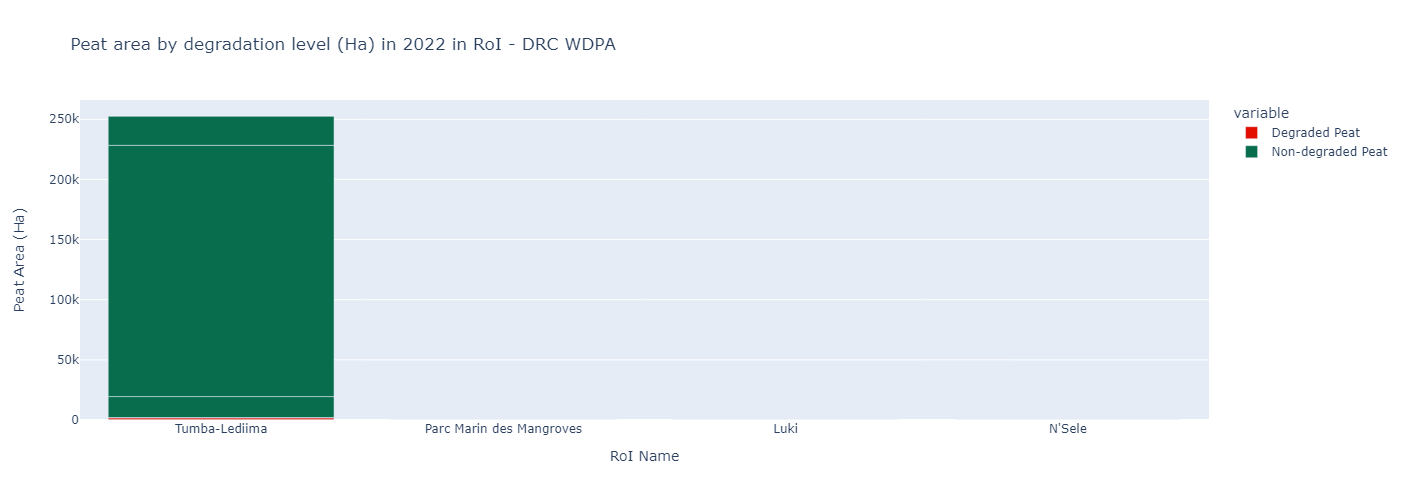

In [35]:
# Degraded Peat area in RoI
fig_degpeatarea_22 = px.bar(degradation_peatforestype_2022_df, x = roi_column_name, y = ["Degraded Peat", "Non-degraded Peat"],
                         category_orders={"Degraded Peat": ["Degraded Peat", "Non-degraded Peat"]},
                         color_discrete_sequence = ['#e30d00', '#076d4d'],
                         width=1400, height=500, 
                         labels = {roi_column_name: "RoI Name","value": "Peat Area (Ha)"},
                         title ="Peat area by degradation level (Ha) in 2022 in RoI - " + projectname)
fig_degpeatarea_22

#### Map - Degraded Peat in 2022

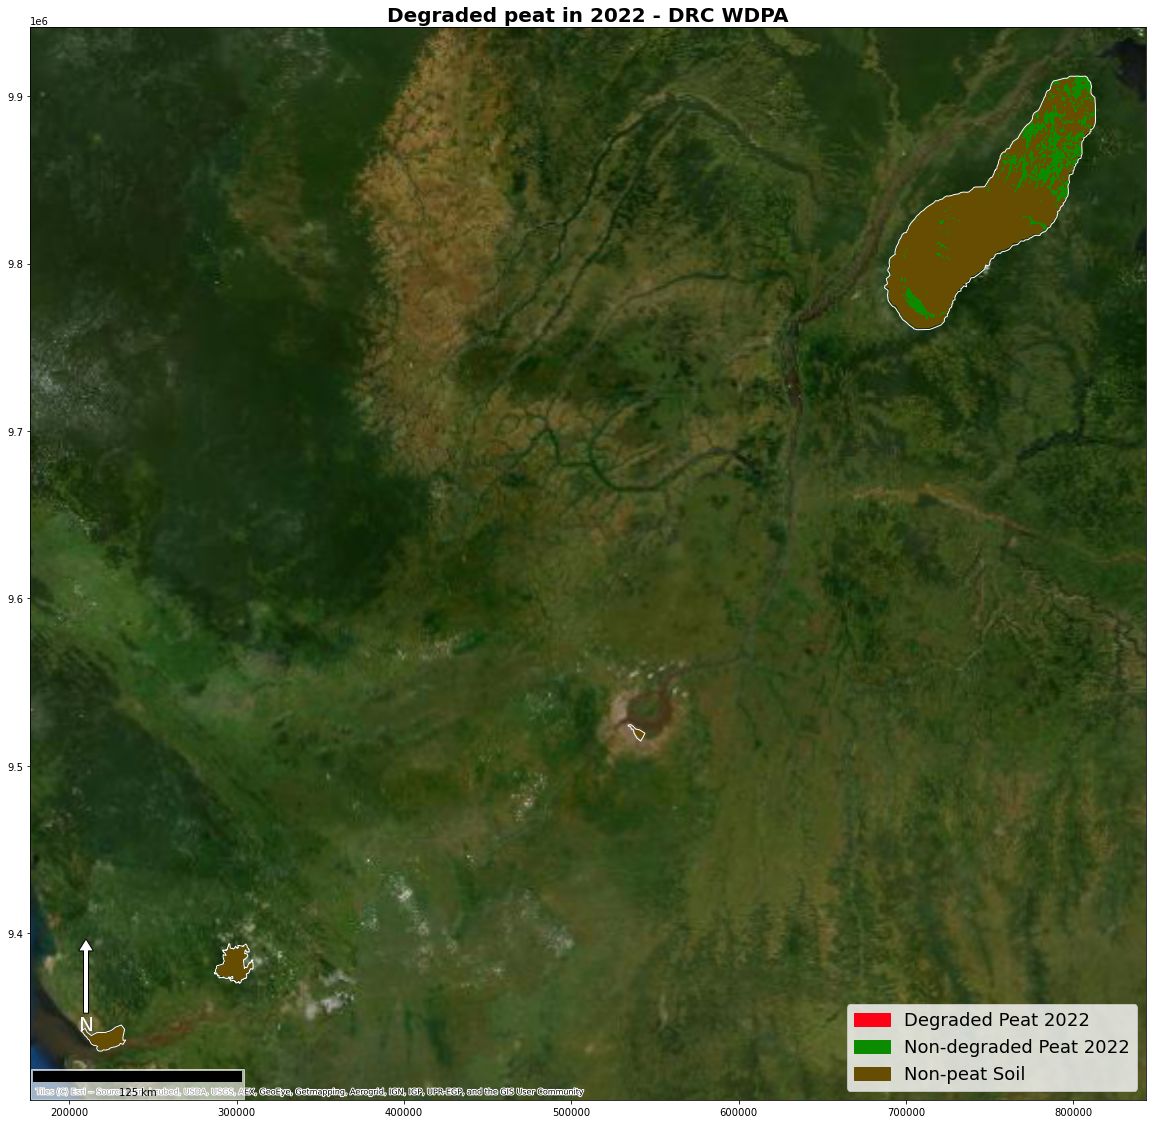

In [36]:
colors_degpeat22 = ['#fc0015','#0b8c00' ,'#674d01']
cmap_degpeat22 = ListedColormap(colors_degpeat22)
norm_degpeat = colors.BoundaryNorm([0, 100.5, 111, 211], ncolors=3) #cmap_degpeat22.N, clip=False)

fig_degpeat22, ax_degpeat22 = plt.subplots(figsize=(20,20))


x, y, arrow_length = 0.05, 0.15, 0.08
ax_degpeat22.annotate('N', color='white', xy=(x, y), xytext=(x, y-arrow_length),
                      arrowprops=dict(facecolor='white', width=5, headwidth=15),
                      ha='center', va='center', fontsize=20,
                      xycoords=ax_degpeat22.transAxes)

ax_degpeat22.set_title(label='Degraded peat in 2022 - '+  projectname, fontsize=20, fontweight="bold")

legend_labels_degpeat22 = {"#fc0015": "Degraded Peat 2022",
                           "#0b8c00" : "Non-degraded Peat 2022",
                           "#674d01" : "Non-peat Soil"}
patches_degpeat22 = [Patch(color=color, label=label)
                     for color, label in legend_labels_degpeat22.items()]
ax_degpeat22.legend(handles=patches_degpeat22,facecolor="white", prop={'size': 18}, loc='lower right')
ax_degpeat22.add_artist(ScaleBar(1, box_alpha=0.6, location = 'lower left'))
ax_degpeat22 = roi_proj.plot(figsize=(20, 20), color = None, edgecolor = 'white', facecolor="none", ax = ax_degpeat22)
ax_degpeat22 = ctx.add_basemap(source=ctx.providers.Esri.WorldImagery, crs=roi_proj.crs.to_string(), ax = ax_degpeat22 )
ax_degpeat22 = rasterio.plot.show(pnp_forest_2022, ax=ax_degpeat22, cmap = cmap_degpeat22, norm = norm_degpeat)

### Annual Forest Loss on Peat 2001-2021

In [37]:
# 1. overlay peat with primary forest loss
upperleft_bound3 = AnnualprimaryforestLoss_geotiff.transform * (0, 0)
pixel_size3 = AnnualprimaryforestLoss_geotiff.transform[0]

PrimaryLoss_2001_2021_overlay =  peatnonpeat_raster.read(1) * 100 + AnnualprimaryforestLoss_geotiff.read(1)

new_transform3 = rasterio.transform.from_origin(upperleft_bound3[0],upperleft_bound3[1],pixel_size3,pixel_size3)

new_dataset_PrimaryLoss = rasterio.open(
    os.path.join(raster_directory, projectname + '_PNP_PrimaryLoss_02_21_roi.tif').replace(os.sep, '/'), "w+", compress="LZW",
    driver = "GTiff",
    height = PrimaryLoss_2001_2021_overlay.shape[0],
    width = PrimaryLoss_2001_2021_overlay.shape[1],
    count = 1,
    nodata = 0,
    dtype = PrimaryLoss_2001_2021_overlay.dtype,
    crs = projection,
    transform = new_transform3
)
new_dataset_PrimaryLoss.write(PrimaryLoss_2001_2021_overlay, 1)
new_dataset_PrimaryLoss.close()

# 2. overlay peat with non-primary forest loss
upperleft_bound4 = AnnualNonprimaryforestLoss_geotiff.transform * (0, 0)
pixel_size4 = AnnualNonprimaryforestLoss_geotiff.transform[0]

NonPrimaryLoss_2001_2021_overlay = peatnonpeat_raster.read(1) * 100 + AnnualNonprimaryforestLoss_geotiff.read(1)

new_transform4 = rasterio.transform.from_origin(upperleft_bound4[0],upperleft_bound4[1],pixel_size4,pixel_size4)

new_dataset_NonnPrimaryLoss = rasterio.open(
    os.path.join(raster_directory, projectname + '_PNP_NonPrimaryLoss_01_21_roi.tif').replace(os.sep, '/'), "w+", compress="LZW",
    driver = "GTiff",
    height = NonPrimaryLoss_2001_2021_overlay.shape[0],
    width = NonPrimaryLoss_2001_2021_overlay.shape[1],
    count = 1,
    nodata = 0,
    dtype = NonPrimaryLoss_2001_2021_overlay.dtype,
    crs = projection,
    transform = new_transform4
)
new_dataset_NonnPrimaryLoss.write(NonPrimaryLoss_2001_2021_overlay, 1)
new_dataset_NonnPrimaryLoss.close()

In [84]:
PrimayLoss_PNP_02_21 = rasterio.open(os.path.join(raster_directory, projectname + '_PNP_PrimaryLoss_02_21_roi.tif').replace(os.sep, '/'))
NonPrimayLoss_PNP_01_21 = rasterio.open(os.path.join(raster_directory, projectname + '_PNP_NonPrimaryLoss_01_21_roi.tif').replace(os.sep, '/'))

In [38]:
# 1. Annual Primary Forest Loss - Zonal Statistic
za_primLoss_pnp_02_21 = zonal_stats(vectors = peat_nonpeat_roi_proj['geometry'], 
                                        raster = os.path.join(raster_directory, projectname + '_PNP_PrimaryLoss_02_21_roi.tif').replace(os.sep, '/'), categorical=True)
za_primLoss_pnp_02_21_df = pd.DataFrame(za_primLoss_pnp_02_21).fillna(0)
# Estimate Area from pixels count
za_primLoss_pnp_02_21_df = za_primLoss_pnp_02_21_df * 30 *30 /10000
za_primLoss_pnp_02_21_df["total_area_ha"] = za_primLoss_pnp_02_21_df.sum(axis=1)

# rename coloumn based on degradation category
za_primLoss_pnp_02_21_df = za_primLoss_pnp_02_21_df.rename({100.0: 'NonLoss', 101.0: 'Peat_PrimLoss1', 102.0 : 'Peat_PrimLoss2', 103.0 : 'Peat_PrimLoss3', 104.0 : 'Peat_PrimLoss4', 
                                                                    105.0: 'Peat_PrimLoss5', 106.0: 'Peat_PrimLoss6', 107.0 : 'Peat_PrimLoss7', 108.0 : 'Peat_PrimLoss8', 109.0 : 'Peat_PrimLoss9',
                                                                    110.0: 'Peat_PrimLoss10', 111.0: 'Peat_PrimLoss11', 112.0 : 'Peat_PrimLoss12', 113.0 : 'Peat_PrimLoss13', 114.0 : 'Peat_PrimLoss14',
                                                                    115.0: 'Peat_PrimLoss15', 116.0: 'Peat_PrimLoss16', 117.0 : 'Peat_PrimLoss17', 118.0 : 'Peat_PrimLoss18', 119.0 : 'Peat_PrimLoss19',
                                                                    120.0: 'Peat_PrimLoss20', 121.0: 'Peat_PrimLoss21',
                                                                    200.0: 'NonLoss', 201.0: 'NonPeat_PrimLoss1', 202.0 : 'NonPeat_PrimLoss2', 203.0 : 'NonPeat_PrimLoss3', 204.0 : 'NonPeat_PrimLoss4', 
                                                                    205.0: 'NonPeat_PrimLoss5', 206.0: 'NonPeat_PrimLoss6', 207.0 : 'NonPeat_PrimLoss7', 208.0 : 'NonPeat_PrimLoss8', 209.0 : 'NonPeat_PrimLoss9',
                                                                    210.0: 'NonPeat_PrimLoss10', 211.0: 'NonPeat_PrimLoss11', 212.0 : 'NonPeat_PrimLoss12', 213.0 : 'NonPeat_PrimLoss13', 214.0 : 'NonPeat_PrimLoss14',
                                                                    215.0: 'NonPeat_PrimLoss15', 216.0: 'NonPeat_PrimLoss16', 217.0 : 'NonPeat_PrimLoss17', 218.0 : 'NonPeat_PrimLoss18', 219.0 : 'NonPeat_PrimLoss19',
                                                                    220.0: 'NonPeat_PrimLoss20', 221.0: 'NonPeat_PrimLoss21',}, axis='columns')
# sum the duplicated columns
za_primLoss_pnp_02_21_df = za_primLoss_pnp_02_21_df.groupby(lambda x:x, axis=1).sum()

In [39]:
# 2. Annual Non-Primary Forest Loss - Zonal Statistic
za_NonprimLoss_pnp_01_21 = zonal_stats(vectors = peat_nonpeat_roi_proj['geometry'], 
                                        raster = os.path.join(raster_directory, projectname + '_PNP_NonPrimaryLoss_01_21_roi.tif').replace(os.sep, '/'), categorical=True)
za_NonprimLoss_pnp_01_21_df = pd.DataFrame(za_NonprimLoss_pnp_01_21).fillna(0)
# Estimate Area from pixels count
za_NonprimLoss_pnp_01_21_df = za_NonprimLoss_pnp_01_21_df * 30 *30 /10000
za_NonprimLoss_pnp_01_21_df["total_area_ha"] = za_NonprimLoss_pnp_01_21_df.sum(axis=1)

# rename coloumn based on degradation category
za_NonprimLoss_pnp_01_21_df = za_NonprimLoss_pnp_01_21_df.rename({100.0: 'NonLoss', 101.0: 'Peat_NonPrimLoss1', 102.0 : 'Peat_NonPrimLoss2', 103.0 : 'Peat_NonPrimLoss3', 104.0 : 'Peat_NonPrimLoss4', 
                                                                    105.0: 'Peat_NonPrimLoss5', 106.0: 'Peat_NonPrimLoss6', 107.0 : 'Peat_NonPrimLoss7', 108.0 : 'Peat_NonPrimLoss8', 109.0 : 'Peat_NonPrimLoss9',
                                                                    110.0: 'Peat_NonPrimLoss10', 111.0: 'Peat_NonPrimLoss11', 112.0 : 'Peat_NonPrimLoss12', 113.0 : 'Peat_NonPrimLoss13', 114.0 : 'Peat_NonPrimLoss14',
                                                                    115.0: 'Peat_NonPrimLoss15', 116.0: 'Peat_NonPrimLoss16', 117.0 : 'Peat_NonPrimLoss17', 118.0 : 'Peat_NonPrimLoss18', 119.0 : 'Peat_NonPrimLoss19',
                                                                    120.0: 'Peat_NonPrimLoss20', 121.0: 'Peat_NonPrimLoss21',
                                                                    200.0: 'NonLoss', 201.0: 'NonPeat_NonPrimLoss1', 202.0 : 'NonPeat_NonPrimLoss2', 203.0 : 'NonPeat_NonPrimLoss3', 204.0 : 'NonPeat_NonPrimLoss4', 
                                                                    205.0: 'NonPeat_NonPrimLoss5', 206.0: 'NonPeat_NonPrimLoss6', 207.0 : 'NonPeat_NonPrimLoss7', 208.0 : 'NonPeat_NonPrimLoss8', 209.0 : 'NonPeat_NonPrimLoss9',
                                                                    210.0: 'NonPeat_NonPrimLoss10', 211.0: 'NonPeat_NonPrimLoss11', 212.0 : 'NonPeat_NonPrimLoss12', 213.0 : 'NonPeat_NonPrimLoss13', 214.0 : 'NonPeat_NonPrimLoss14',
                                                                    215.0: 'NonPeat_NonPrimLoss15', 216.0: 'NonPeat_NonPrimLoss16', 217.0 : 'NonPeat_NonPrimLoss17', 218.0 : 'NonPeat_NonPrimLoss18', 219.0 : 'NonPeat_NonPrimLoss19',
                                                                    220.0: 'NonPeat_NonPrimLoss20', 221.0: 'NonPeat_NonPrimLoss21',}, axis='columns')
# sum the duplicated columns
za_NonprimLoss_pnp_01_21_df = za_NonprimLoss_pnp_01_21_df.groupby(lambda x:x, axis=1).sum()

In [40]:
# join with roi
deforestation_peattype_2001_2022 = peat_nonpeat_roi_proj.join(za_primLoss_pnp_02_21_df)
deforestation_peattype_2001_2022 = peat_nonpeat_roi_proj.join(za_NonprimLoss_pnp_01_21_df)
deforestation_peattype_2001_2022_df = pd.DataFrame(deforestation_peattype_2001_2022).fillna(0)
deforestation_peattype_2001_2022_df = deforestation_peattype_2001_2022_df.loc[(deforestation_peattype_2001_2022_df[[roi_column_name]] != 0).all(axis=1)]

## Export Data

In [41]:
# Export csv file
# 1. Degraded peat based on Forested area in 2000 and 2001
degradation_peatforestype_2001_df = degradation_peatforestype_2001_df.drop('geometry', axis =1 )
degradation_peatforestype_2001_df.to_csv(os.path.join(out_dir, projectname + '_RoI_DegradedPeat_2001.csv'))
#degradation_peatforestype_2000.to_file(os.path.join(out_dir, projectname + '_RoI_DegradedPeat_2000_2001.shp'))

# 2. Degraded peat based on Forested area in 2022
degradation_peatforestype_2022_df = degradation_peatforestype_2022_df.drop('geometry', axis =1)
degradation_peatforestype_2022_df.to_csv(os.path.join(out_dir, projectname + '_RoI_DegradedPeat_2022.csv'))
#degradation_peatforestype_2022.to_file(os.path.join(out_dir, projectname + '_RoI_DegradedPeat_2022.shp'))

# 3. Deforestation on Peat
deforestation_peattype_2001_2022_df.to_csv(os.path.join(out_dir, projectname + '_RoI_Deforestation_2001_2021.csv'))

In [42]:
# Export Grapph
# 1. Degraded peat in 2000/2001
fig_degpeatarea_01.write_image(os.path.join(out_dir, projectname + '_RoI_DegradedPeatArea_2001_Graph.png'))
# 2. Degraded peat in 2022
fig_degpeatarea_22.write_image(os.path.join(out_dir, projectname + '_RoI_DegradedPeatArea_2022_Graph.png'))

In [43]:
# Export Map
# 1. Degraded Peat in 2000/2001
fig_degpeat01.savefig(os.path.join(out_dir, projectname + '_DegradedPeat_2001_Map.png'), facecolor='white',  bbox_inches='tight')
# 2. Degraded Peat in 2022
fig_degpeat22.savefig(os.path.join(out_dir, projectname + '_DegradedPeat_2022_Map.png'), facecolor='white',  bbox_inches='tight')